In [1]:
import sys
import os
main_path = os.path.abspath(os.path.join(os.path.dirname("./test_text_generation.ipynb"), '..'))
sys.path.insert(0, main_path)

In [2]:
from src.feature_extraction.text.text_generation import TextGeneration
from src.feature_extraction.text.count_words import Vectorizer
from src.preprocesing import gen_dataset, gen_dataset_from_h5
from src.feature_extraction.window_slider import TwoWaysSlider

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import Normalizer
from scipy.stats import norm
from scipy import sparse

In [12]:
merged_labels_to_num = {
    "Single microlens": 1,
    "TDE": 2,
    "Short period VS": 3,
    "SN": 4,
    "M-dwarf": 5,
    "AGN": 6,
    "Unknown": 99
}

merged_labels = {
    6: "Single microlens",
    15: "TDE",
    16: "Short period VS",
    42: "SN",
    52: "SN",
    53: "Short period VS",
    62: "SN",
    64: "SN",
    65: "M-dwarf",
    67: "SN",
    88: "AGN",
    90: "SN",
    92: "Short period VS",
    95: "SN",
    99: "Unknown"
}

# res, labels, metadata = gen_dataset_from_h5("plasticc_balanced_combined_classes_small_ddf")
res, labels, metadata = gen_dataset_from_h5("plasticc_augment_ddf_100")
bands = ["lsstg", "lssti", "lsstr", "lsstu", "lssty", "lsstz"]
spatial_comp = np.sum([len(ts.observations["flux"]) * 2 for ts in res])
time_durations = np.array([ts.observations["time"].to_numpy()[-1] - ts.observations["time"].to_numpy()[0] for ts in res])
mean_time = np.mean(time_durations)
std_time = np.std(time_durations)
print(mean_time, std_time)

k = spatial_comp // len(res)
print("target k:", k)
labels_merged = np.array([merged_labels_to_num[merged_labels[x]] for x in labels])
print("classes:", np.unique(labels_merged))

Object: 100%|██████████████████████████████████████████████████████████████████| 1307/1307 [00:00<00:00, 327593.84it/s]

767.782131591315 214.20004371685755
target k: 580
classes: [1 2 3 4 5 6]


In [28]:
for r in res[np.where(labels == 64)[0]]:
    print(r.metadata["object_id"])

plasticc_000062187
plasticc_000062187_aug_CtUEmnPVHZ
plasticc_000062187_aug_SatBBjpAOX
plasticc_000062187_aug_dANwIcsPbz
plasticc_000062187_aug_eChSoOsbBg
plasticc_000062187_aug_iEAFSMhjAs
plasticc_000062187_aug_jQkhZElJiz
plasticc_000062187_aug_kqabpQAvnn
plasticc_000062187_aug_nJtBgmcZAS
plasticc_000062187_aug_nvIDkNptpn
plasticc_000062187_aug_pEXKuZGwML
plasticc_000062187_aug_qqzgltiRnh
plasticc_000062187_aug_ruFEgwFrBA
plasticc_000062187_aug_zTfwIIVZjR
plasticc_000139362
plasticc_000139362_aug_EolnGAeeCV
plasticc_000139362_aug_QkQxnDHGbW
plasticc_000139362_aug_VeRzizUFOR
plasticc_000139362_aug_WEqYrfkrwz
plasticc_000139362_aug_aPYhecCbwg
plasticc_000139362_aug_jYiCOefrPT
plasticc_000139362_aug_juRXuvmXNp
plasticc_000139362_aug_lPXySpXkBY
plasticc_000139362_aug_oJblKegjfG
plasticc_000139362_aug_rqsYIzAdNr


In [41]:
idxs = np.where(labels == 64)[0][14:14+6]
idxs = np.where(labels == 64)[0][0:0+6]
orig = res[idxs[0]]
idxs = np.where(labels == 64)[0][5:5+6]
col = []
for i in idxs[1:]:
    print(res[i].metadata["object_id"])
    col.append(res[i])
    

plasticc_000062187_aug_jQkhZElJiz
plasticc_000062187_aug_kqabpQAvnn
plasticc_000062187_aug_nJtBgmcZAS
plasticc_000062187_aug_nvIDkNptpn
plasticc_000062187_aug_pEXKuZGwML


In [39]:
target = "plasticc_000004173"
col = []
orig = None
for r in res:
    if r.metadata["reference_object_id"] == target:
        col.append(r)
    elif r.metadata["object_id"] == target:
        orig = r

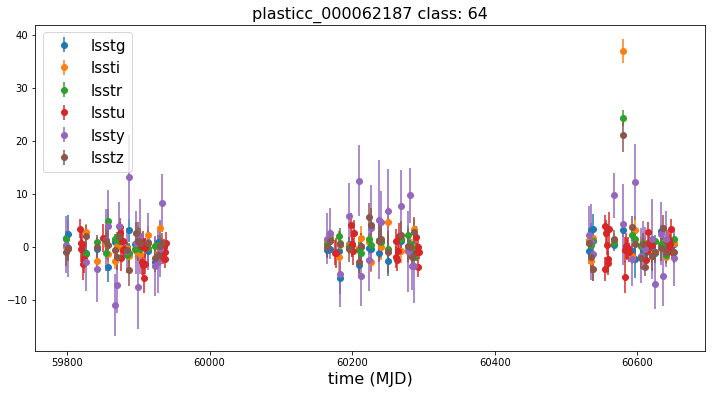

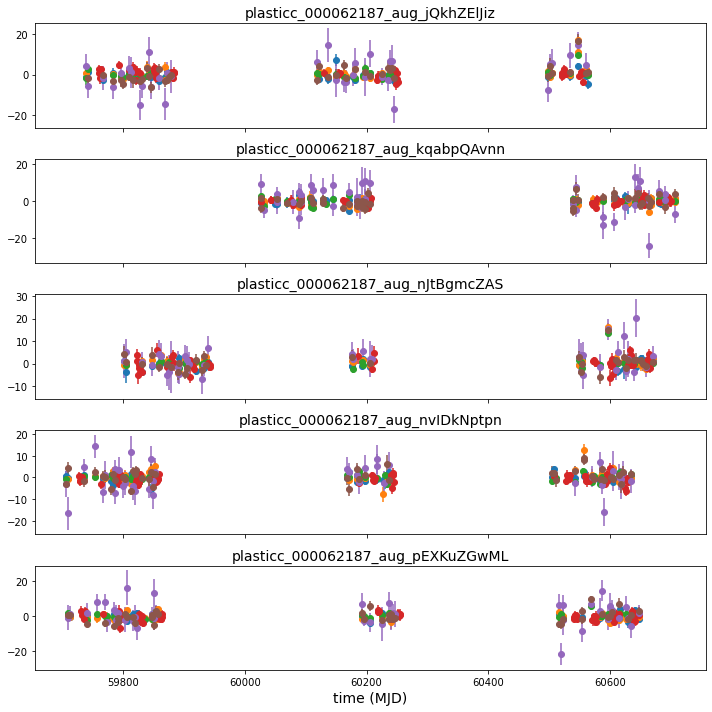

In [42]:
data = orig.observations
g = data.groupby("band")
fig = plt.figure(figsize=(12, 6))
for k, v in g:
#     if k != "lssti":
#         continue
    plt.errorbar(v["time"], v["flux"], fmt="o", yerr=v["flux_error"], label=k)
plt.title(orig.metadata["object_id"] + " class: " + str(orig.metadata["class"]), fontsize=16)
plt.xlabel("time (MJD)", fontsize=16)
plt.legend(fontsize=15)


fig, ax = plt.subplots(5, 1, figsize=(10, 10), sharex=True)
for i in range(5):
    r = col[i]
    data = r.observations
    g = data.groupby("band")
    for k, v in g:
        ax[i].errorbar(v["time"], v["flux"], fmt="o", yerr=v["flux_error"], label=k)
    ax[i].set_title(r.metadata["object_id"], fontsize=14)
    
ax[4].set_xlabel("time (MJD)", fontsize=14)
plt.tight_layout()

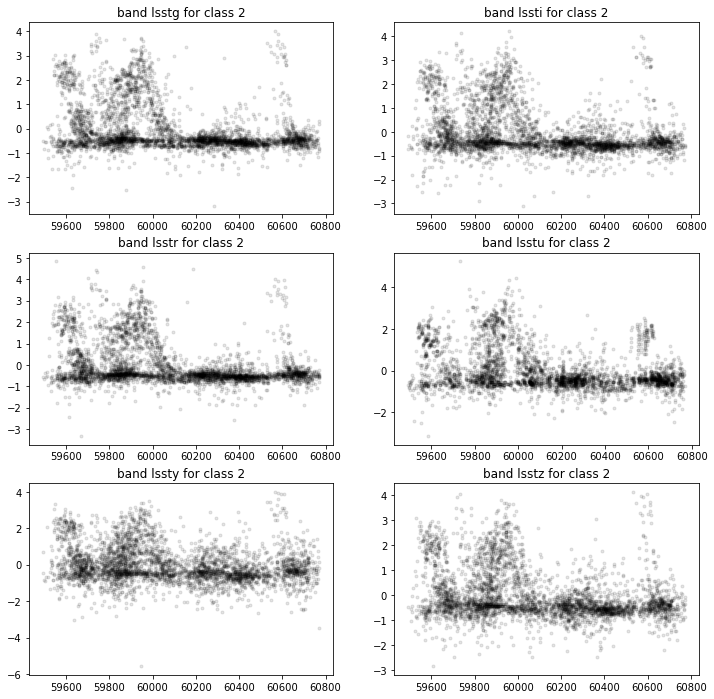

In [4]:
lbl = 2
a = np.where(labels_merged == lbl)[0]
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
ki = {
    "lsstg": [0, 0],
    "lssti": [0, 1],
    "lsstr": [1, 0],
    "lsstu": [1, 1],
    "lssty": [2, 0],
    "lsstz": [2, 1]
}
for i in a:
    # plot by bands
    data = res[i].observations
    data = data.sort_values("time")
    g = data.groupby("band")
    for k, v in g:
        ax_i, ax_j = ki[k]
        flux = v["flux"].to_numpy()
        flux = (flux - np.mean(flux)) / np.std(flux)
        ax[ax_i][ax_j].plot(v["time"], flux, ".", color="k", alpha=0.1,  label=k)

for k, ij in ki.items():
    ax_i, ax_j = ij
    ax[ax_i][ax_j].set_title("band %s for class %s" % (k, lbl))

In [5]:
window = 100
wl = 5
sub_win = window / wl
ts = res[a[27]]
data = ts.observations

time width: 458.85435657352355


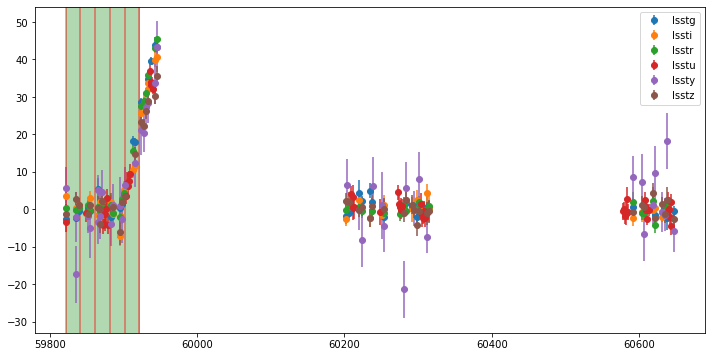

In [6]:
print("time width:", data["time"].to_numpy()[-1] - data["time"].to_numpy()[0])
# data = data.sort_values("time")
g = data.groupby("band")
fig = plt.figure(figsize=(12, 6))
for k, v in g:
    plt.errorbar(v["time"], v["flux"], fmt="o", yerr=v["flux_error"], label=k)

ini_time = data["time"].to_numpy()[0]
# plt.axvline(ini_time, color="k")
plt.axvspan(ini_time, ini_time + window, color="g", alpha=0.3)
for i in range(0, wl+1):
    plt.axvline(ini_time + sub_win * i, color="r", alpha=0.5)
plt.legend()

(59820.502086367305, 59922.502086367305)

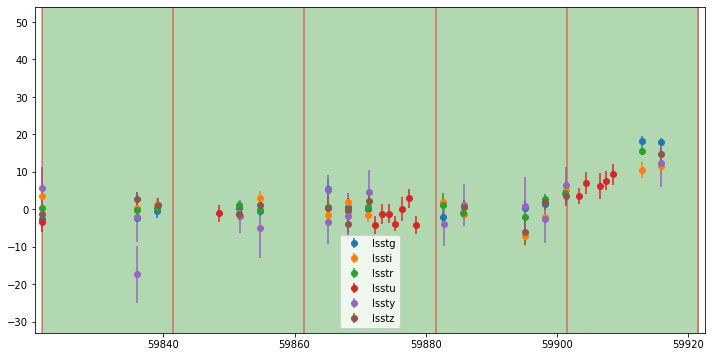

In [7]:
g = data.groupby("band")
fig = plt.figure(figsize=(12, 6))
for k, v in g:
    plt.errorbar(v["time"], v["flux"], fmt="o", yerr=v["flux_error"], label=k)

ini_time = data["time"].to_numpy()[0]
# plt.axvline(ini_time, color="k")
plt.axvspan(ini_time, ini_time + window, color="g", alpha=0.3)
for i in range(0, wl+1):
    plt.axvline(ini_time + sub_win * i, color="r", alpha=0.5)
plt.legend()
plt.xlim([ini_time - 1, ini_time + window + 1])

(-8.0, 15.0)

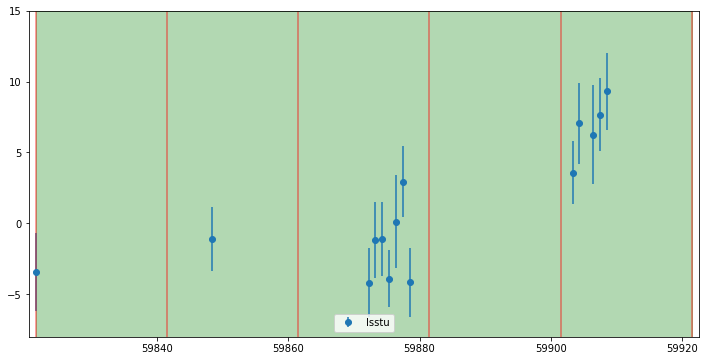

In [8]:
g = data.groupby("band")
fig = plt.figure(figsize=(12, 6))
k = "lsstu"
for k2, v in g:
    if k2 == k:
        plt.errorbar(v["time"], v["flux"], fmt="o", yerr=v["flux_error"], label=k)

ini_time = data["time"].to_numpy()[0]
# plt.axvline(ini_time, color="k")
plt.axvspan(ini_time, ini_time + window, color="g", alpha=0.3)
for i in range(0, wl+1):
    plt.axvline(ini_time + sub_win * i, color="r", alpha=0.5)
plt.legend()
plt.xlim([ini_time - 1, ini_time + window + 1])
plt.ylim([-8, 15])

first value of 'lsstu' band is time: 59872.28976267123


(59872.28976267123, 59972.28976267123)

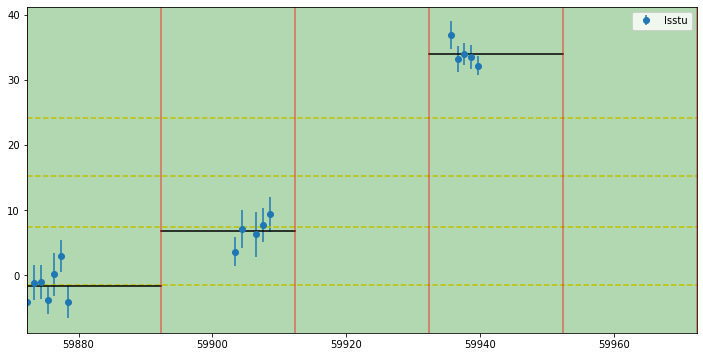

In [9]:
data2 = data.sort_values("time")
g = data2.groupby("band")
fig = plt.figure(figsize=(12, 6))
k = "lsstu"
for k2, v in g:
    if k2 == k:
        print("first value of '%s' band is time:" % k, v["time"].to_numpy()[2])
        plt.errorbar(v["time"].to_numpy()[2:19], v["flux"].to_numpy()[2:19], fmt="o", yerr=v["flux_error"].to_numpy()[2:19], label=k)
        ini_time = v["time"].to_numpy()[2]
        _mean = np.mean(v["flux"].to_numpy()[2:19])
        _std = np.std(v["flux"].to_numpy()[2:19])
        _c1 = np.mean(v["flux"].to_numpy()[2:9])
        _c2 = np.mean(v["flux"].to_numpy()[9:14])
        _c4 = np.mean(v["flux"].to_numpy()[14:19])

bp = norm.ppf(np.linspace(0, 1, 5 + 1)[1:-1], _mean, _std)
for _bp in bp:
    plt.axhline(_bp, linestyle="--", color='y')
    
plt.axhline(y=_c1, xmin=0, xmax=sub_win/window, color="k")
plt.axhline(y=_c2, xmin=sub_win/window, xmax=2 * sub_win/window, color="k")
plt.axhline(y=_c4, xmin=3*sub_win/window, xmax=4 * sub_win/window, color="k")
        
# plt.axvline(ini_time, color="k")
plt.axvspan(ini_time, ini_time + window, color="g", alpha=0.3)
for i in range(0, wl+1):
    plt.axvline(ini_time + sub_win * i, color="r", alpha=0.5)
plt.legend()
plt.xlim([ini_time, ini_time + window])
# plt.ylim([-8, 15])

first value of 'lsstu' band is time: 59903.34031594995


(59903.34031594995, 60003.34031594995)

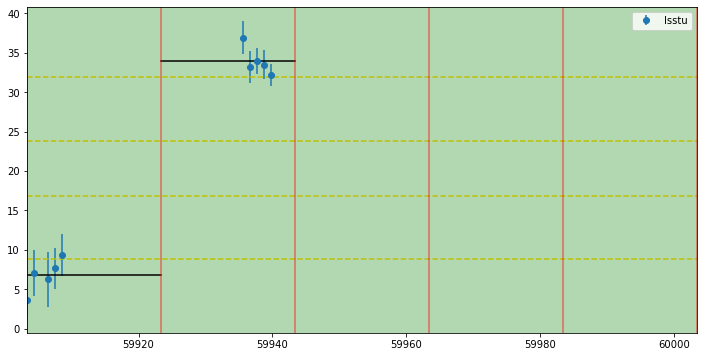

In [10]:
data2 = data.sort_values("time")
g = data2.groupby("band")
fig = plt.figure(figsize=(12, 6))
k = "lsstu"
ini=9
end=19
for k2, v in g:
    if k2 == k:
        print("first value of '%s' band is time:" % k, v["time"].to_numpy()[ini])
        plt.errorbar(v["time"].to_numpy()[ini:end], v["flux"].to_numpy()[ini:end], fmt="o", yerr=v["flux_error"].to_numpy()[ini:end], label=k)
        ini_time = v["time"].to_numpy()[ini]
        _mean = np.mean(v["flux"].to_numpy()[ini:end])
        _std = np.std(v["flux"].to_numpy()[ini:end])
        _c1 = np.mean(v["flux"].to_numpy()[ini:ini + 5])
        _c2 = np.mean(v["flux"].to_numpy()[ini+5:ini+10])
#         _c4 = np.mean(v["flux"].to_numpy()[14:19])

bp = norm.ppf(np.linspace(0, 1, 5 + 1)[1:-1], _mean, _std)
for _bp in bp:
    plt.axhline(_bp, linestyle="--", color='y')
    
plt.axhline(y=_c1, xmin=0, xmax=sub_win/window, color="k")
plt.axhline(y=_c2, xmin=sub_win/window, xmax=2 * sub_win/window, color="k")
# plt.axhline(y=_c4, xmin=3*sub_win/window, xmax=4 * sub_win/window, color="k")
        
# plt.axvline(ini_time, color="k")
plt.axvspan(ini_time, ini_time + window, color="g", alpha=0.3)
for i in range(0, wl+1):
    plt.axvline(ini_time + sub_win * i, color="r", alpha=0.5)
plt.legend()
plt.xlim([ini_time, ini_time + window])
# plt.ylim([-8, 15])

In [70]:
window = 11
wl = 2
alph_size = 4
quantity = "mean"
num_reduction=True
irr_handler="supp_interp"
index_based_paa = False
tol = wl * 1
mean_bp_dist="normal"
threshold = 1
verbose=False
gen = TextGeneration(window, wl, alph_size=alph_size, quantity=quantity,
                    num_reduction=num_reduction, irr_handler=irr_handler,
                    index_based_paa=index_based_paa, tol=tol, mean_bp_dist=mean_bp_dist,
                    threshold=threshold, verbose=verbose)

In [71]:
slider = TwoWaysSlider(window, tol=tol)
doc, dropped_failed = gen.transform_object(ts, slider)

In [72]:
print(doc)

{'lsstg': [6, 9, 2], 'lssti': [6, 9, 6], 'lsstr': [12, 9, 6], 'lsstu': [6, 2, 6, 10, 14, 6, 2, 6, 10, 14, 6, 2, 6, 10, 14], 'lssty': [9], 'lsstz': [9, 2, 6, 10, 14, 9, 6, 9]}


In [64]:
corpus = np.array([doc])
_BANDS = ["lsstg", "lssti", "lsstr", "lsstu", "lssty", "lsstz"]
vec= Vectorizer(gen.bop_size, _BANDS)
count = vec.transform(corpus)
sparse.csr_matrix(count)

<1x6144 sparse matrix of type '<class 'numpy.intc'>'
	with 375 stored elements in Compressed Sparse Row format>

In [15]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [16]:
for i in range(5):
    print(1 + 4 + 32 + 128 + (-256 * -i))

165
421
677
933
1189


In [17]:
# slider = TwoWaysSlider(window, tol=tol)

# _BANDS = ["lsstg", "lssti", "lsstr", "lsstu", "lssty", "lsstz"]
# ts_obj = ts.to_fast_irregular_uts_object(_BANDS)

# doc_mb = {b: [] for b in _BANDS}
# dropped_mb = 0
# all_none = True
# for k, v in ts_obj.items():
#     if k != "lsstu":
#         continue
#     if v is not None:
#         print("BAND:", k)
#         print("first emasured time:", v.times[0])
#         slider.fit(v.times)
#         doc, dropped = gen._transform(v, slider)
#         doc_mb[k] = doc
#         dropped_mb += dropped
#         if len(doc) > 0:
#             all_none = False
#     else:
#         doc_mb[k] = None
# if all_none:
#     doc_mb = None


In [18]:
# from itertools import product
# alph = ["a", "b", "c", "d", "#"]
# vocabulary = [a+b+c+d+e for a,b,c,d,e in product("".join(alph), repeat=5)]
# vocabulary[2856]

In [19]:
# from itertools import product
# alph = ["a", "b", "c", "d"]
# vocabulary = [a+b+c+d+e for a,b,c,d,e in product("".join(alph), repeat=5)]
# vocabulary[661]